In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim
from matplotlib.widgets import Slider
import time
from torchmetrics.classification import Dice
import glob
from tqdm.notebook import tqdm
from torchvision.ops import sigmoid_focal_loss
from torch.utils.data import DataLoader, Dataset

device = 'cuda'

Data Acquisition

In [3]:
def binary(data, threshold):
    return (data > threshold).float()

In [4]:
class Data(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [5]:
def normalize(scans):
    return (scans - scans.min()) / (scans.max() - scans.min())

In [6]:
paths_scan = glob.glob('/home/jkitzmann/final_project/final_project_data/training_scans/**/*.nrrd', recursive=True)
seg_img_path = glob.glob('/home/jkitzmann/final_project/final_project_data/training_labels/**/*.nrrd', recursive=True)

paths_seg = []
for seg in seg_img_path:
    try:
        for scan in paths_scan:
            if seg.split('/')[-1].split('_')[0] == scan.split('/')[-1].split('_')[0] and seg not in paths_seg:
                paths_seg.append(seg)
    except:
        print(seg)

for idx, seg in enumerate(paths_seg):
    try:
        if seg.split('/')[-1].split('_')[0] != paths_scan[idx].split('/')[-1].split('_')[0]:
            paths_scan.remove(paths_scan[idx])
    except IndexError:
        print(seg)
        paths_scan.remove(paths_scan[idx])

scans=[]
segs=[]

desired_size = (40,40,40)
for idx, scan_path in enumerate(paths_scan):
    scan = sitk.GetArrayFromImage(sitk.ReadImage(scan_path))
    seg = sitk.GetArrayFromImage(sitk.ReadImage(paths_seg[idx]))

    if scan.shape == desired_size and seg.shape == desired_size:
        scans.append(scan)
        segs.append(seg)


scans = np.array(scans)
segs = np.array(segs)

segs[segs == 255.0] = 1.0

X_train, X_test, Y_train, Y_test = train_test_split(scans, segs, test_size=round(scans.shape[0]*.2))
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = round(X_train.shape[0]*.2))

X_train = torch.from_numpy(X_train).unsqueeze(1).float().to(device)
X_test = torch.from_numpy(X_test).unsqueeze(1).float().to(device)
X_val = torch.from_numpy(X_val).unsqueeze(1).float().to(device)
Y_val = torch.from_numpy(Y_val).unsqueeze(1).float().to(device)
Y_train = torch.from_numpy(Y_train).unsqueeze(1).float().to(device)
Y_test = torch.from_numpy(Y_test).unsqueeze(1).float().to(device)


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([142, 1, 40, 40, 40])
torch.Size([36, 1, 40, 40, 40])
torch.Size([44, 1, 40, 40, 40])


Image Visualization Functions

In [7]:
volume_norm = plt.Normalize(vmin=-1000, vmax=100)
segmentation_norm = plt.Normalize(vmin = 0, vmax = 1)

def show_images_2d(slice_ax, scan_num, scan, seg, pred):
    plt.subplot(1,3,1)
    plt.imshow(convert_img(scan[scan_num])[slice_ax,:,:], cmap='gray')
    plt.title('Nodule')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(convert_img(seg[scan_num])[slice_ax,:,:], cmap='gray')
    plt.title('Segmentation')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(convert_img(pred[scan_num][slice_ax,:,:]), cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

def show_images_3d(slice_ax, scan_num, scan, seg, pred, scan_masked = np.zeros(4)):
    plt.subplot(1,4,1)
    plt.imshow(convert_img(scan[scan_num])[0, slice_ax,:,:], cmap='gray', norm = volume_norm)
    plt.title('Nodule')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(convert_img(seg[scan_num])[0, slice_ax,:,:], cmap='gray', norm = segmentation_norm)
    plt.title('Segmentation')
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.imshow(convert_img(pred[scan_num][0, slice_ax,:,:]), cmap='gray', norm = segmentation_norm)
    plt.title('Prediction')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(convert_img(scan_masked[scan_num][0, slice_ax,:,:]), cmap='gray', norm = volume_norm)
    plt.title('Masked Image')
    plt.axis('off')

def convert_img(img):
    return np.array(img.detach().to('cpu'))

Network Structure

In [8]:
class UNet(nn.Module):
    def __init__(self, 
                 in_channels=1,   
                 out_channels=1,  # 1 for binary segmentation
                 features=[64, 128, 256, 512]):  # Number of feature maps for each layer
        super(UNet, self).__init__()
        
        self.downs = nn.ModuleList()  # Down convolutions
        self.ups = nn.ModuleList()    # Up convolutions
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)  # Max pooling for 3D

        # down convolutions
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature  # Update in_channels for next layer
            
        # bottleneck layer
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # up convolutions
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))  # Transpose convolution
            self.ups.append(DoubleConv(feature * 2, feature))
            
        # Final output layer (segmentation output)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)  # Output layer for segmentation

    def forward(self, x):
        skip_connections = []

        # Downward pass: encoding layers
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck (lowest part of U-Net)
        x = self.bottleneck(x)

        # Reverse the skip connections for upward pass
        skip_connections = skip_connections[::-1]

        # Upward pass: decoding layers
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Transpose convolution (upscale)
            skip_connection = skip_connections[idx // 2]

            # Resize if needed (if the sizes mismatch)
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])

            # Concatenate skip connection with the upsampled feature map
            x = torch.cat((skip_connection, x), dim=1)  # Concatenate along the channel dimension
            x = self.ups[idx + 1](x)  # Apply the second double convolution
        return self.final_conv(x)
        
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

Loss Functions

In [9]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

#PyTorch
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

from torch.autograd import Variable
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        # if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
        # if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = nn.functional.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

#PyTorch
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

Accuracy Metrics

In [10]:
def dice_coefficient(tensor1, tensor2, threshold=.5):
    # Apply threshold to tensors to binarize them (values >= threshold become 1, else 0)
    tensor1 = (tensor1 >= threshold).float()
    tensor2 = (tensor2 >= threshold).float()
    
    # Compute the intersection and the union
    intersection = torch.sum(tensor1 * tensor2)
    union = torch.sum(tensor1) + torch.sum(tensor2)
    
    # Calculate Dice score
    if union == 0:
        return torch.tensor(1.0)  # Dice score is 1 if both tensors are empty
    else:
        return 2 * intersection / union

Training Loop

In [11]:
def train(model, data_loader, val_loader, optimizer, loss_function, scaler, epochs, progress_bar, device="cuda"):
    train_loss_history = []
    val_loss_history = []
    
    # Move the model to the specified device
    model.to(device)

    # Set up the progress bar
    if progress_bar:
        epochs_range = tqdm(range(epochs))
    else:
        epochs_range = range(epochs)

    for epoch in epochs_range:
        # Training loop
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        for idx, data in enumerate(data_loader):
            scans, segs = data

            # Forward pass with automatic mixed precision
            with torch.amp.autocast(device):
                predictions = model(scans)
                loss = loss_function(predictions, segs)

            # Backward pass and optimizer step
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(data_loader)
        train_loss_history.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                scans, segs = data
                scans, segs = scans.to(device), segs.to(device)

                # Forward pass
                with torch.amp.autocast(device):
                    predictions = model(scans)
                    val_loss = loss_function(predictions, segs)

                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Update progress bar with losses
        if progress_bar:
            epochs_range.set_description(
                f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
            )

    return train_loss_history, val_loss_history

General Testing

In [ ]:
# Parameters
model = UNet(1,1).to(device)
loss_function = DiceLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
batch_size = 4
epochs = 500
scaler = torch.amp.GradScaler(device)
train_data = Data(X_train.to('cuda'), Y_train.to('cuda'))
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = Data(X_val.to('cuda'), Y_val.to('cuda'))
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
train_loss_history, val_loss_history = train(model, train_data_loader, val_data_loader, optimizer, loss_function, scaler, epochs, progress_bar=True)
# Plot loss per epoch
plt.plot(train_loss_history)
plt.ylabel('loss')
plt.xlabel('N Epochs')
plt.plot(val_loss_history)
plt.show()

In [ ]:
# save network
torch.save(model.state_dict(), '/home/jkitzmann/final_project/model_states/nov26_24.pth')

In [11]:
# load network
model = UNet()
model.load_state_dict(torch.load('/home/jkitzmann/final_project/model_states/nov26_24.pth', weights_only=True))
model.eval()

UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

CPU Conversion and Prediction Visualization

In [12]:
print(X_test.shape)

X_train = X_train.to('cpu')
X_test = X_test.to('cpu')
Y_train = Y_train.to('cpu')
Y_test = Y_test.to('cpu')
X_val = X_val.to('cpu')
Y_val = Y_val.to('cpu')

test_predictions = model(X_test)
test_predictions = binary(test_predictions, 5)
test_predictions = test_predictions.to('cpu')

torch.Size([44, 1, 40, 40, 40])


tensor(0.8607)


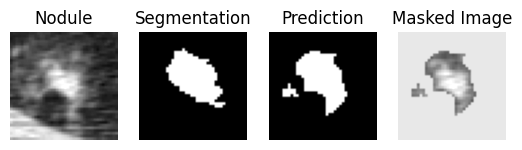

In [20]:
masked_nodules = np.multiply(X_test, binary(test_predictions, .5))


test_num = 0
accuracies = []

for idx, pred in enumerate(test_predictions):
    accuracies.append(dice_coefficient(pred, Y_test[idx], .2))

# for idx, a in enumerate(accuracies):
#     print(idx, a)
    
show_images_3d(20, test_num, X_test, Y_test, binary(test_predictions,.5), masked_nodules)
print(accuracies[test_num])

average: 0.8371383547782898


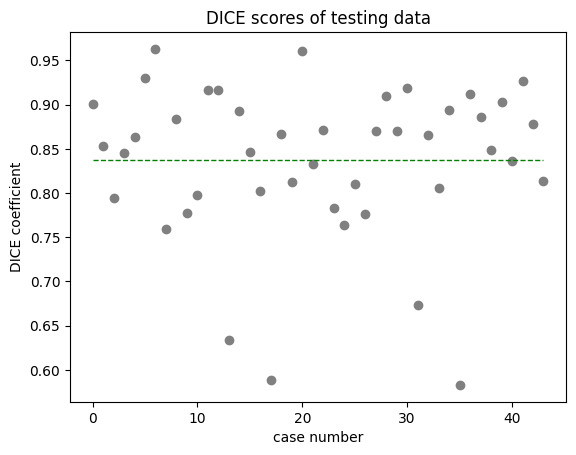

In [33]:
dice_scores = []
for idx, pred in enumerate(test_predictions):
    dc = dice_coefficient(pred, Y_test[idx])
    if dc > .2:
        dice_scores.append(dc)

x = range(0,len(dice_scores))
y = dice_scores

plt.scatter(x, y, color='gray')

avg = np.mean(dice_scores)

#add trendline to plot
plt.plot(x, avg * np.ones(len(x)), color="green", linewidth=1, linestyle="--")
plt.title('DICE scores of testing data')
plt.ylabel('DICE coefficient')
plt.xlabel('case number')

print(f'average: {np.mean(dice_scores)}')

Epoch Optimization

In [ ]:
model = UNet().to(device) # change out channels for multi-class seg
loss_function = DiceLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
batch_size = 16
scaler = torch.amp.GradScaler(device)
# Creating the DataLoader
train_data = Data(X_train, Y_train)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = Data(X_val, Y_val)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

epoch_accuracies = []

for epoch_num in tqdm(range(3, 500, 20)):
    loss_history, predictions = train(model, train_data_loader, val_data_loader, optimizer, loss_function, scaler, epoch_num, progress_bar=True)
    test_predictions = model(X_test)
    accuracy = dice_coefficient(test_predictions, Y_test, .2)
    epoch_accuracies.append(accuracy)
    
plt.plot(epoch_accuracies)

In [ ]:
epoch_acc_np = []
for acc in epoch_accuracies:
    epoch_acc_np.append(acc.detach().to('cpu'))

In [ ]:
plt.plot(range(0,303,20), epoch_acc_np)
plt.xlabel('epochs')
plt.ylabel('average DICE of predictions')

Learning Rate Optimization

In [ ]:
model = UNet().to(device) # change out channels for multi-class seg
loss_function = DiceLoss()
lrs = [1e-6, 500e-5, 1e-5, 500e-4, 1e-4, 500e-3, 1e-3, 500e-2, 1e-2]
epochs = 50
batch_size = 16
scaler = torch.amp.GradScaler(device)
# Creating the DataLoader
train_data = Data(X_train, Y_train)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = Data(X_val, Y_val)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

lr_accuracies = []

epoch_accuracies = []

for lr in tqdm(lrs):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history, predictions = train(model, train_data_loader, val_data_loader, optimizer, loss_function, scaler, epochs, progress_bar=True)
    test_predictions = model(X_test)
    accuracy = dice_coefficient(test_predictions, Y_test, .2)
    epoch_accuracies.append(accuracy)
    
lr_acc_np = []
for acc in lr_accuracies:
    lr_acc.append(acc.detach().to('cpu'))

plt.plot(lr_acc_np)
plt.xlabel('epochs')
plt.ylabel('average DICE of predictions')

Loss Function Optimization

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'average DICE of predictions')

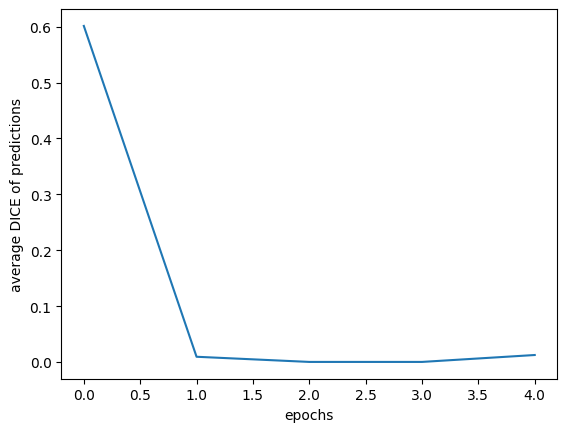

In [11]:
loss_functions = [DiceLoss(), TverskyLoss(), nn.BCEWithLogitsLoss(), nn.CrossEntropyLoss(), IoULoss()]
loss_acc = []

model = UNet().to(device) # change out channels for multi-class seg
lr = 1e-3
epochs = 50
batch_size = 16
scaler = torch.amp.GradScaler(device)
# Creating the DataLoader
train_data = Data(X_train, Y_train)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = Data(X_val, Y_val)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=lr)

for loss_function in tqdm(loss_functions):
    loss_history, predictions = train(model, train_data_loader, val_data_loader, optimizer, loss_function, scaler, epochs, progress_bar=True)
    test_predictions = model(X_test)
    accuracy = dice_coefficient(test_predictions, Y_test, .2)
    loss_acc.append(accuracy)
    
loss_acc_np = []
for acc in loss_acc:
    loss_acc_np.append(acc.detach().to('cpu'))

plt.plot(loss_acc_np)
plt.xlabel('epochs')
plt.ylabel('average DICE of predictions')

Batch Size Optimization

In [20]:
batch_sizes = []
batch_acc = []

model = UNet().to(device) # change out channels for multi-class seg
lr = 1e-3
epochs = 100
batches = range(2,200,10)
loss_function = DiceLoss()
scaler = torch.amp.GradScaler(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


for batch_size in tqdm(batches):
    # Creating the DataLoader
    train_data = Data(X_train, Y_train)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data = Data(X_val, Y_val)
    val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    loss_history, predictions = train(model, train_data_loader, val_data_loader, optimizer, loss_function, scaler, epochs, progress_bar=True)
    test_predictions = model(X_test)
    accuracy = dice_coefficient(test_predictions, Y_test, .2)
    batch_acc.append(accuracy)
    
batch_acc_np = []
for acc in batch_acc:
    batch_acc_np.append(acc.detach().to('cpu'))

plt.plot(batch_acc_np)
plt.xlabel('epochs')
plt.ylabel('average DICE of predictions')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 21.95 GiB of which 692.12 MiB is free. Process 1052103 has 21.27 GiB memory in use. Of the allocated memory 19.90 GiB is allocated by PyTorch, and 1.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)